In [19]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Positive, Interval

from lafomo.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from lafomo.plot import Plotter, plot_phase, Colours
from lafomo.configuration import VariationalConfiguration
from lafomo.trainers import VariationalTrainer

import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
Num training points:  13


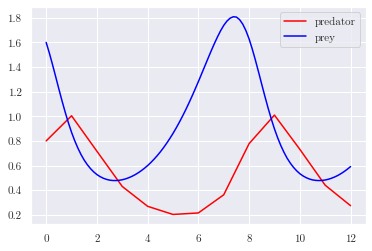

In [2]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=0.8,
)
x_min, x_max = min(dataset.times), max(dataset.times)

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]
num_inducing = 12

print('Num training points: ', num_training)
output_names = np.array(['pred','prey'])

In [3]:
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 1.5)
        self.raw_decay = Parameter(self.positivity.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.true_f = dataset.prey[::3].unsqueeze(0).repeat(self.config.num_samples, 1).unsqueeze(1)
        print(self.true_f.shape)
    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        # print(t, self.t_index, self.f.shape, self.true_f.shape)
        # f shape (num_samples, num_outputs, num_times)
        f = self.f[:, :, self.t_index].unsqueeze(2)
        # f = self.true_f[:, :, self.t_index].unsqueeze(2)
        dh = self.growth_rate * h * f - self.decay_rate * h
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

tensor(12.)
torch.Size([70, 1, 33])


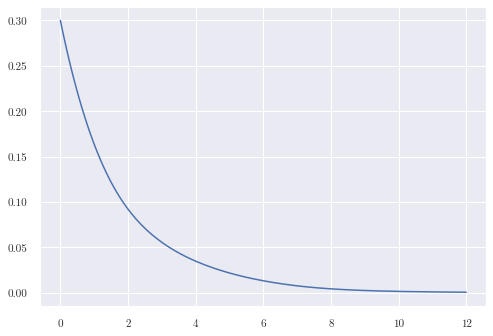

In [4]:
use_natural = False
config = VariationalConfiguration(
    num_samples=70,
    initial_conditions=False # TODO
)
print(x_max)
inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

periodic = True
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
with torch.no_grad():
    mean_module.constant -= 0.2

if periodic:
    covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])) * \
        gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
        batch_shape=torch.Size([num_latents])
    )

    # print(covar_module.base_kernel.kernels)
    covar_module.base_kernel.kernels[0].lengthscale = 3
    covar_module.base_kernel.kernels[0].period_length = 8
    covar_module.base_kernel.kernels[1].lengthscale = 2
else:
    covar_module = gpytorch.kernels.RBFKernel(
        batch_shape=torch.Size([num_latents]),
        lengthscale_constraint=Interval(1, 6))
    covar_module.lengthscale = 2
gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, num_latents,
                         natural=use_natural)
lfm = LotkaVolterra(num_outputs, gp_model, config, num_training_points=num_training)

plotter = Plotter(lfm, np.array(['predator']))

out = lfm(t_predict, step_size=1e-2)
plt.plot(t_predict, out.mean.detach())

In [5]:
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=50
)

In [10]:
trainer.train(500, report_interval=10, step_size=1e-1)

Epoch 501/1000 - Loss: -0.08 (-0.80 0.71) kernel: [[[3.0777068]]]
Epoch 511/1000 - Loss: -0.13 (-0.89 0.76) kernel: [[[3.1425]]]
Epoch 521/1000 - Loss: -0.13 (-0.90 0.77) kernel: [[[3.1781232]]]
Epoch 531/1000 - Loss: -0.07 (-0.84 0.78) kernel: [[[3.2344816]]]
Epoch 541/1000 - Loss: -0.26 (-1.06 0.80) kernel: [[[3.247836]]]
Epoch 551/1000 - Loss: -0.24 (-1.07 0.84) kernel: [[[3.3217368]]]
Epoch 561/1000 - Loss: -0.23 (-1.11 0.88) kernel: [[[3.3763778]]]
Epoch 571/1000 - Loss: -0.21 (-1.10 0.89) kernel: [[[3.4021447]]]
Epoch 581/1000 - Loss: -0.04 (-0.96 0.92) kernel: [[[3.4429917]]]
Epoch 591/1000 - Loss: 0.00 (-0.94 0.95) kernel: [[[3.4958293]]]
Epoch 601/1000 - Loss: -0.11 (-1.03 0.91) kernel: [[[3.5526814]]]
Epoch 611/1000 - Loss: -0.12 (-1.00 0.87) kernel: [[[3.5819986]]]
Epoch 621/1000 - Loss: -0.21 (-1.08 0.87) kernel: [[[3.6179438]]]
Epoch 631/1000 - Loss: -0.25 (-1.13 0.88) kernel: [[[3.6684568]]]
Epoch 641/1000 - Loss: -0.32 (-1.22 0.90) kernel: [[[3.689697]]]
Epoch 651/1000 -

In [14]:
print(covar_module.base_kernel.kernels[0].period_length)
print(covar_module.base_kernel.kernels[0].lengthscale)
print(covar_module.outputscale)
# print(covar_module.base_kernel.period_length)
# covar_module.kernels[0].period_length += 1.

tensor([[[12.3331]]], grad_fn=<SoftplusBackward>)
tensor([[[4.6897]]], grad_fn=<SoftplusBackward>)
tensor([1.1596], grad_fn=<SoftplusBackward>)


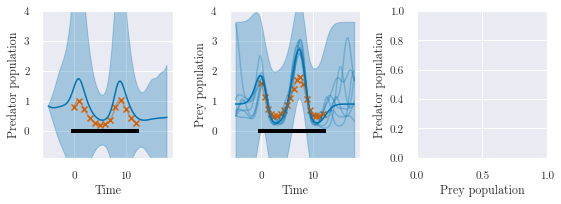

In [21]:
lfm.eval()
t_predict = torch.linspace(-5, 18, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=1e-2)
q_f = lfm.predict_f(t_predict)

fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
plotter.plot_gp(lfm(t_predict), t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=(-0.9, 4),
                titles=None, ax=axes[0])
axes[0].plot(dataset.times, dataset.predator, alpha=0.5, color=Colours.scatter_color)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Predator population')

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                t_scatter=dataset.times[::5],
                y_scatter=dataset.prey[None, None, ::5],
                ylim=(-0.9, 4),
                titles=None, ax=axes[1])
axes[1].plot(dataset.times, dataset.prey, alpha=0.5, color=Colours.scatter_color)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Prey population')

real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = q_m

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

# plot_phase(x_samples, y_samples,
#            x_mean=softplus(prey_mean),
#            y_mean=predator_mean,
#            x_target=real_prey,
#            y_target=real_pred,
#            ax=axes[2])
axes[2].set_xlabel('Prey population')
axes[2].set_ylabel('Predator population')
plt.tight_layout()

In [13]:
print(lfm.decay_rate, lfm.growth_rate)
print(dict(lfm.gp_model.mean_module.named_parameters()))
# with torch.no_grad():
#     lfm.raw_initial -= 0.1

tensor([[0.6439]], dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.5188]], dtype=torch.float64, grad_fn=<LogBackward>)
{'constant': Parameter containing:
tensor([[0.3603]], requires_grad=True)}


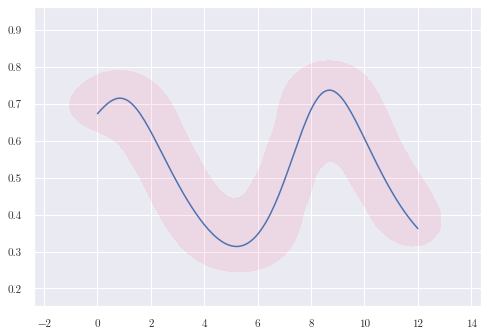

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())